# Finding angles with gradient descent

[Michaël Defferrard](https://deff.ch), EPFL LTS2

Notebook showing best practices in TensorFlow v2 to optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{i,j} \left| d_Q(Q_i, Q_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $Q_i$ is a unit quaternion representing a 3D rotation and $d_Q$ is the distance between two rotations.

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{i,j} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

TODO:
* Try to use `tf.data` as input pipeline.
  Should make shuffling, sampling, pre-fetching, caching, batching, and transformations (like computing $d_p$ and adding noise to images) easy.
  Is there a way to make it work like PyTorch datasets?
* Can we use `tf.keras.layers.Embedding` for `angles_predicted`?
* Optimizations (e.g., parallel computations).

In [1]:
#!pip install --upgrade tensorflow==2.0.0
#!pip install --upgrade tensorflow-graphics
# !pip install tensorboard==1.12.0

In [2]:
from time import time

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_graphics.geometry.transformation import quaternion

## 1 Data

In [3]:
n_samples = 100
#n_samples = 1000  # Takes more time.
angles_true = [quaternion.normalized_random_uniform([1]) for _ in range(n_samples)]
print(f'{len(angles_true)} tensors of shape {angles_true[0].shape}')

# Sanity check: the quaternions represent rotations, i.e., are normalized.
assert abs(tf.reduce_mean(tf.norm(angles_true, axis=2) - tf.ones(n_samples))) < 1e-5

100 tensors of shape (1, 4)


In [4]:
# TODO: why isn't this zero? Numerical errors?
# This discrepancy is of the same order as the loss we attain.
tf.reduce_mean(quaternion.relative_angle(angles_true, angles_true))

<tf.Tensor: id=1733, shape=(), dtype=float32, numpy=0.002772792>

## 2 Loss and gradient

In [5]:
def loss(q1_predicted, q2_predicted, distance_target):
    q1 = quaternion.normalize(q1_predicted)
    q2 = quaternion.normalize(q2_predicted)
    distance = quaternion.relative_angle(q1, q2)
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

# Sanity check: zero loss at solution.
distance_target = quaternion.relative_angle(angles_true[0:3], angles_true[1:4])
assert loss(angles_true[0:3], angles_true[1:4], distance_target) < 1e-10

In [6]:
def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
    return loss_value, tape.gradient(loss_value, q1_predicted + q2_predicted)

# Sanity check: zero gradient at solution.
q1 = [tf.Variable(angles_true[i]) for i in [0, 1, 2]]
q2 = [tf.Variable(angles_true[i]) for i in [1, 2, 3]]
distance_target = quaternion.relative_angle(q1, q2)
loss_value, gradients = gradient(q1, q2, distance_target)
assert abs(loss_value) < 1e-5
assert tf.reduce_all(tf.convert_to_tensor(gradients) < 1e-5 * tf.ones([6, 1, 4]))

## 3 Optimization loop

step 200/2000 (11s): loss = 1.66e-01
step 400/2000 (21s): loss = 1.34e-01
step 600/2000 (32s): loss = 1.28e-01
step 800/2000 (42s): loss = 1.01e-01
step 1000/2000 (52s): loss = 8.83e-02
step 1200/2000 (63s): loss = 7.41e-02
step 1400/2000 (73s): loss = 9.44e-02
step 1600/2000 (84s): loss = 3.60e-02
step 1800/2000 (94s): loss = 1.08e-02
step 2000/2000 (105s): loss = 1.69e-08


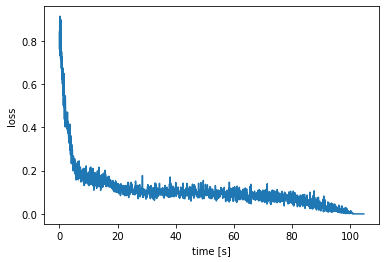

In [7]:
batch_size = 256
steps = 2000

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Random initialization.
angles_predicted = [tf.Variable(quaternion.normalized_random_uniform([1])) for _ in range(n_samples)]

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1 = list(np.random.randint(0, n_samples, batch_size))
    idx2 = list(np.random.randint(0, n_samples, batch_size))
    q1 = [angles_predicted[i] for i in idx1]
    q2 = [angles_predicted[i] for i in idx2]

    # Compute distances between pairs.
    # To be replaced by distance estimation in pixel space.
    q1_true = [angles_true[i] for i in idx1]
    q2_true = [angles_true[i] for i in idx2]
    distance_target = quaternion.relative_angle(q1_true, q2_true)

    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(q1, q2, distance_target)
    optimizer.apply_gradients(zip(gradients, q1 + q2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

In [8]:
# Not a big deal if they're not normalized. Only the direction matters.
# tf.norm(angles_predicted, axis=2)